# HUCKEL Molecular Orbital (HMO) Calculations

### CHEM344  Physical Chemistry
#### Department of Chemistry
#### Illinois Institute of Technology

#### Original Bash Code By Jingbai Li
#### Translated to Python by Joseph DePaolo-Boisvert
#### HUCKELMO Version 2.0  Aug 30th 2017
#### Nov 1st, 2022



In [1]:
import numpy as np
from numpy import real
import glob
import math
import matplotlib.pyplot as plt
%matplotlib inline

Some Example Calculations using numpy arrays

In [20]:
a, b = np.arange(1,9), np.arange(15,23)
print(a,b)

[1 2 3 4 5 6 7 8] [15 16 17 18 19 20 21 22]


In [21]:
#Pairwise Operations
print(a+b)
print(b-a)
print(a*b)
print(b/a)

[16 18 20 22 24 26 28 30]
[14 14 14 14 14 14 14 14]
[ 15  32  51  72  95 120 147 176]
[15.          8.          5.66666667  4.5         3.8         3.33333333
  3.          2.75      ]


In [18]:
a, b = a.reshape((2,4)), b.reshape((2, 4))
print(a)
print(b)
#Try running the cell above

[[1 2 3 4]
 [5 6 7 8]]
[[15 16 17 18]
 [19 20 21 22]]


## Molecular Orbitals Calculation

The cell below will mount your google drive, making files from drive accessible.
Specify your directory on drive that contains the input structures from github, if you do not see the structures files listed below (output 2 cells below) raise your hand.

In [2]:
from IPython.testing import test
from google.colab import drive
drive.mount('/content/drive')
##################################################################
structures_dir = '/content/drive/MyDrive/Huckel/structures/'###### CHANGE ME
################################################################## WITH TRAILING SLASH

Mounted at /content/drive


In [3]:
mol2s = glob.glob(f'{structures_dir}*.mol2')
print(mol2s)

['/content/drive/MyDrive/Huckel/structures/11DIETHYL44DICARBOCYANINE.mol2', '/content/drive/MyDrive/Huckel/structures/benzene.mol2', '/content/drive/MyDrive/Huckel/structures/11DIETHYL44CARBOCYANINE.mol2', '/content/drive/MyDrive/Huckel/structures/11DIETHYL22DICARBOCYANINE.mol2', '/content/drive/MyDrive/Huckel/structures/11DIETHYL22CYANINE.mol2', '/content/drive/MyDrive/Huckel/structures/benzene-test.mol2', '/content/drive/MyDrive/Huckel/structures/11DIETHYL22CYANINE-new.mol2', '/content/drive/MyDrive/Huckel/structures/11DIETHYL22DICARBOCYANINE-new.mol2', '/content/drive/MyDrive/Huckel/structures/11DIETHYL44CARBOCYANINE-new.mol2', '/content/drive/MyDrive/Huckel/structures/11DIETHYL44DICARBOCYANINE-new.mol2']


In [33]:
#Installing py3Dmol using pip
!pip install py3Dmol
import py3Dmol as py3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
view = py3.view()
mol2 = mol2s[6]
view.addModel(open(mol2, 'r').read(),'mol2')
print(mol2)
view.setBackgroundColor('black')
view.setStyle({'stick': {'radius': .1}, 'sphere': {'scale': 0.25}})
view.zoomTo()
view.show()

/content/drive/MyDrive/Huckel/structures/11DIETHYL22CYANINE-new.mol2


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The cell below contains helper functions that we will use to complete the calculations.

get_matrix(mol2_fn)\
Will take a string that points to a mol2 file, then parse it to build the overlap matrix.  The output will be this matrix, the number of pi electrons, and the number of MOs
returns mol2_name, matrix, ele_num, orbs

analyze_matrix(mol2_name, matrix, ele_num, orbs)\
Takes the output of get_matrix() and analyzes it to determine the HOMO and LUMO, as well as the orbital energies.
returns xs, ys

plot_data(title, xs, ys, xlabel, ylabel)\
A helper function to plot x, y data, as well as provide a title and labels.

In [26]:
alpha=1.292              #electrostatic
beta=-3.26934291633      #covalent


def get_matrix(mol2_fn):
    mol2_name = mol2_fn.split('/')[-1]
    # #Initial Parameters
    ele_num=0                #electrons
    orb=0                    #orbitals
    # alpha beta types: 1:C=C-C 2:C-N-C 3:C=N-C
    # diagonal-alpha, alpha’=alpha + h * beta, C=C:0 C=N:2 C-N:1.5
    # connected-beta, beta’=k*beta, C=C:1 C=N:1 C-N:0.8
    with open(mol2_fn, 'r') as f:
        lines = [line[:-1] if line.endswith('\n') else line for line in f.readlines()]
    
    atomsec = lines[lines.index("@<TRIPOS>ATOM") + 1:lines.index("@<TRIPOS>BOND")]
    atomsec = [[element for element in atom.split(' ') if element != ''] for atom in atomsec]
    num_atoms = len(lines)
    
    bondsec = lines[lines.index("@<TRIPOS>BOND") + 1 :]
    if bondsec[-1] == '':
        bondsec.pop(-1)
    
    bonds = []
    for bond in bondsec:
        bond = bond.split(' ')
        if bond[-1] == '1':
            bond[-1] = 'S'
        elif bond[-1] == '2':
            bond[-1] = 'D'
        else:
            bond[-1] = 'N'
        bonds.append(bond)
    bondsec = bonds
    numbonds = len(bondsec)
    #print(atomsec)
    #print(bondsec)
    
    # #detect atom type, matrix dimension, diagonal element
    typ = {}
    dim = len(atomsec)
    matrix = np.zeros((dim, dim))
    for atom in atomsec:
        atom_type = atom[-1]
        atom_ind = int(atom[0]) - 1
        if atom_type == 'C':
            valence = 0 #the number of times it is listed in a bond
            for bond in bondsec:
                if atom[0] in bond[1:3]:
                    valence += 1
            if valence < 4:
                typ[atom[0]] = 1
                h = 0.000
                ele_num += 1
                orb += 1
            else:
                typ[atom[0]] = 0
            
        elif atom_type == 'N':
            pyridine = False
            for bond in bondsec:
                if atom[0] in bond and 'D' in bond:
                    pyridine = True
            if pyridine:
                typ[atom[0]] = 3
                h = 2.000
                ele_num += 1
                orb += 1
            else:
                typ[atom[0]] = 2
                h = 1.500
                ele_num += 2 ####
                orb += 1
        
        else:
            typ[atom[0]] = 0
            h = -1 * alpha / beta
        
        matrix[atom_ind, atom_ind] = alpha + h * beta
    #print(typ)
    #print(matrix)
    
    # #detect bond type, none-zero matrix element
    for bond in bonds:
        b1 = bond[1]
        b2 = bond[2]
        if typ[b1] == 0 or typ[b2] == 0:
            k = 0.000
        elif typ[b1] == 2 or typ[b2] == 2:
            k = 0.800
        else:
            k = 1.000
        b1_ind, b2_ind = int(b1) - 1, int(b2) - 1
        matrix[b1_ind, b2_ind] = k * beta
        matrix[b2_ind, b1_ind] = k * beta
    
    return mol2_name, matrix, ele_num, orb


def analyze_matrix(mol2_name, matrix, ele_num, orbs):
    print('####################################################################')
    print(f'####  Begin Analyze {mol2_name}  ####')
    b = np.linalg.eigvals(matrix)
    energies = [element for element in np.sort(real(b)) if element != 0 and element != alpha]
    
    print(f'Num_Electrons = {ele_num}')
    
    base = ele_num // 2
    
    print()
    print('Orbital Energies (au)')
    
    for i in range(len(energies)):
        s = f'{i+1}      {energies[i]:.4f}'
        if i+1  == base: # base is 1 indexed and i is zero
            s = f'{i+1} HOMO {energies[i]:.4f}'
            homo_ind = i
        elif i+1 == base + 1:
            s = f'{i+1} LUMO {energies[i]:.4f}'
            lumo_ind = i
        print(s)
    
    gap_energy = energies[lumo_ind] - energies[homo_ind]
    print()
    print(f'HOMO-LUMO Gap = {gap_energy:.5f} (au)')
    print()
    
    x = np.arange(100,1601)
    y = lambda x, gap_energy : math.sqrt(2/math.pi)/70*math.e**(-2*((x-(2.998*10**8)*10**9/((1.60217656*10**(-19))/(6.626*10**(-34)))/(gap_energy))/70)**2)
    
    return x, y(x, gap_energy)
  
def plot_data(title, xs, ys, xlabel, ylabel):
    plt.clf()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    _ = plt.plot(xs, ys)
    plt.show()

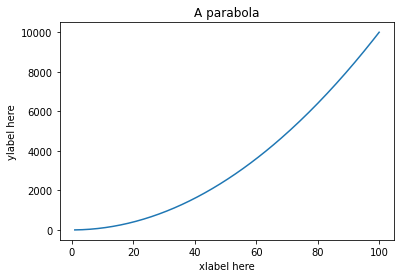

In [29]:
# EXAMPLE on plotting data
xs = np.linspace(1,100,200)
fy = lambda x : x**2
ys = fy(xs)
plot_data("A parabola", xs, ys, 'xlabel here', 'ylabel here')

### Todays Assignment
#### Creating more cells as needed below this message
Utilize the helper functions:

get_matrix(mol2_fn)\
analyze_matrix(mol2_name, matrix, ele_num, orbs)\
plot_data(title, xs, ys, xlabel, ylabel)

Using these three functions, produce the output for all mol2 files available on github.  Also provide a numerical comparison of these results with the results of the previous laboratory which utilized these dyes.  This involves determining the enery of the HOMO-LUMO gap, and determining it's wavelength in nm.  Compare this to results from previous labs in text or code cells.

Note about files labelled "new":\
There are duplicates of each file, one labelled "new" and one that is not.  These files contain critical differences in the bond order between methylene carbons.  Those with the "new" tag have **alternating single and double order bonds** while those without have **aromatic - 1.5 order bonds.**  Consider them different definitions of the bond order for the purpose of the calculation, and compare those with the "new" tag to those without.

Please submit a **pdf** copy of this notebook completely rendered with no interruption (using restart and run all).


In [30]:
# I'll get you started

for mol2_fn in mol2s:
  print(mol2_fn)

/content/drive/MyDrive/Huckel/structures/11DIETHYL44DICARBOCYANINE.mol2
/content/drive/MyDrive/Huckel/structures/benzene.mol2
/content/drive/MyDrive/Huckel/structures/11DIETHYL44CARBOCYANINE.mol2
/content/drive/MyDrive/Huckel/structures/11DIETHYL22DICARBOCYANINE.mol2
/content/drive/MyDrive/Huckel/structures/11DIETHYL22CYANINE.mol2
/content/drive/MyDrive/Huckel/structures/benzene-test.mol2
/content/drive/MyDrive/Huckel/structures/11DIETHYL22CYANINE-new.mol2
/content/drive/MyDrive/Huckel/structures/11DIETHYL22DICARBOCYANINE-new.mol2
/content/drive/MyDrive/Huckel/structures/11DIETHYL44CARBOCYANINE-new.mol2
/content/drive/MyDrive/Huckel/structures/11DIETHYL44DICARBOCYANINE-new.mol2
